In [1]:
import velocycle as vc
from velocycle import *

In [2]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import copy
import scipy
import pycircstat
import pickle

# scRNA-seq
import scanpy as sc
import anndata

In [3]:
from threadpoolctl import threadpool_limits
threadpool_limits(limits=8)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    print("Will use GPU")
    device = torch.device("cuda:0")
else:
    print("Will use CPU")
    device = torch.device("cpu")

Will use GPU


## Load datasets

In [5]:
import anndata

full_adatas = {   
    "RPE_37C_ctrl_Rep1": sc.read_h5ad("Data/RPE_37C_ctrl_Rep1.h5ad"),
    "RPE_37C_ctrl_Rep2": sc.read_h5ad("Data/RPE_37C_ctrl_Rep2.h5ad"),
}

for a in full_adatas.keys(): 
    print(full_adatas[a].shape)
    sc.pp.filter_genes(full_adatas[a], min_cells=int((full_adatas[a].n_obs)*0.05))
    
data = anndata.concat(full_adatas, label="batch", join ="outer")

(4265, 36591)
(9994, 36591)


In [6]:
# Create design matrix for dataset with a single batch
batch_design_matrix = preprocessing.make_design_matrix(data, ids="batch")

In [7]:
# Perform some very basic gene filtering
data = data[:, data.layers["unspliced"].toarray().mean(0) > 0.1].copy()
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.3].copy()
data

AnnData object with n_obs × n_vars = 14259 × 3266
    obs: 'batch', 'n_counts', 'n_genes'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [8]:
# Rough approximation of the cell cycle phase using traditional approaches 
sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [9]:
# Create size normalized data for the phase estimate prior
preprocessing.normalize_total(data)

In [10]:
# Get biologically-relevant gene set to use for velocity estimation
full_keep_genes = utils.get_cycling_gene_set(size="Medium", species="Human")
len(full_keep_genes)

218

## Initialize cycle and phase objects with priors

In [11]:
n_harm = 1
cycle_prior = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=n_harm)

In [12]:
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [13]:
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

if(n_harm==2): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0, 0*nu0, 0*nu0))
if(n_harm==1): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
if(n_harm==0): S_frac_means=nu0[None, :]
cycle_prior.set_means(S_frac_means)

nu0std = np.std(np.log(S+1), axis=0)/2
if(n_harm==2): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std, 0.2*nu0std, 0.2*nu0std))
if(n_harm==1): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
if(n_harm==0): S_frac_stds=nu0[None, :]
cycle_prior.set_stds(S_frac_stds)

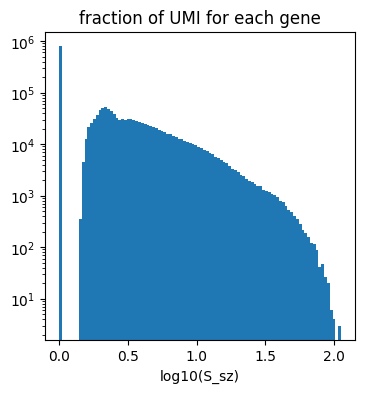

In [14]:
OFFSET=1
fig, ax = plt.subplots(1,1, figsize = (4,4))
ax.set_title('fraction of UMI for each gene')
ax.hist(np.log10(data_to_fit.layers['S_sz'].flatten()+OFFSET), bins = 100)
ax.set_yscale("log")
ax.set_xlabel("log10(S_sz)")
plt.show()

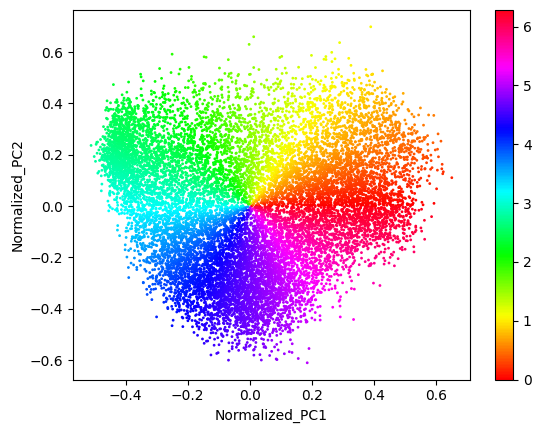

In [15]:
# Obtain a PCA prior for individual cell phases
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, genes_to_use=utils.get_cycling_gene_set(size="Medium", species="Human"),
                                               layer='S_sz', concentration=5.0, plot=True, small_count=OFFSET)

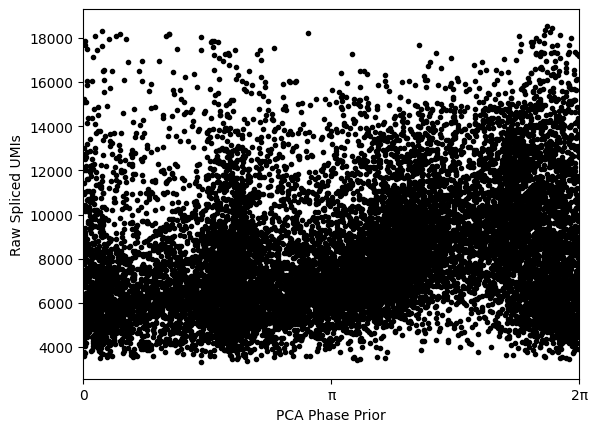

In [16]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

# Run the manifold-learning module

In [17]:
pyro.clear_param_store()

In [18]:
μΔν = torch.zeros((batch_design_matrix.shape[1], S.shape[1], 1)).float().to(device)
σΔν = (torch.ones((batch_design_matrix.shape[1], S.shape[1], 1)) * 0.1).float().to(device)
cix = np.where(batch_design_matrix.sum(0)==data_to_fit.obs["batch"].value_counts().loc["RPE_37C_ctrl_Rep1"])[0][0]

σΔν[cix, :, :] = 0.001

condition_on_dict = {}

In [19]:
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, 
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix.float(),
                                          normalize=False, 
                                          behavior="intersection", 
                                          noisemodel="NegativeBinomial", 
                                          gene_selection_model="all",
                                          n_harmonics=n_harm, 
                                          device=device,
                                          condition_on=condition_on_dict)

phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar,
                          condition_on=condition_on_dict, early_exit=False)

In [20]:
phase_fit.check_model()

 Trace Shapes:                                  
  Param Sites:                                  
 Sample Sites:                                  
    cells dist               |                  
         value         14259 |                  
    genes dist               |                  
         value           136 |                  
  batches dist               |                  
         value             2 |                  
        ν dist     136     1 |     3            
         value     136     1 |     3            
       Δν dist   2 136     1 |                  
         value   2 136     1 |                  
      ϕxy dist         14259 |     2            
         value         14259 |     2            
        ϕ dist               | 14259            
         value               | 14259            
        ζ dist               | 14259 3          
         value               | 14259 3          
    ElogS dist               |     1 1 136 14259
         value      

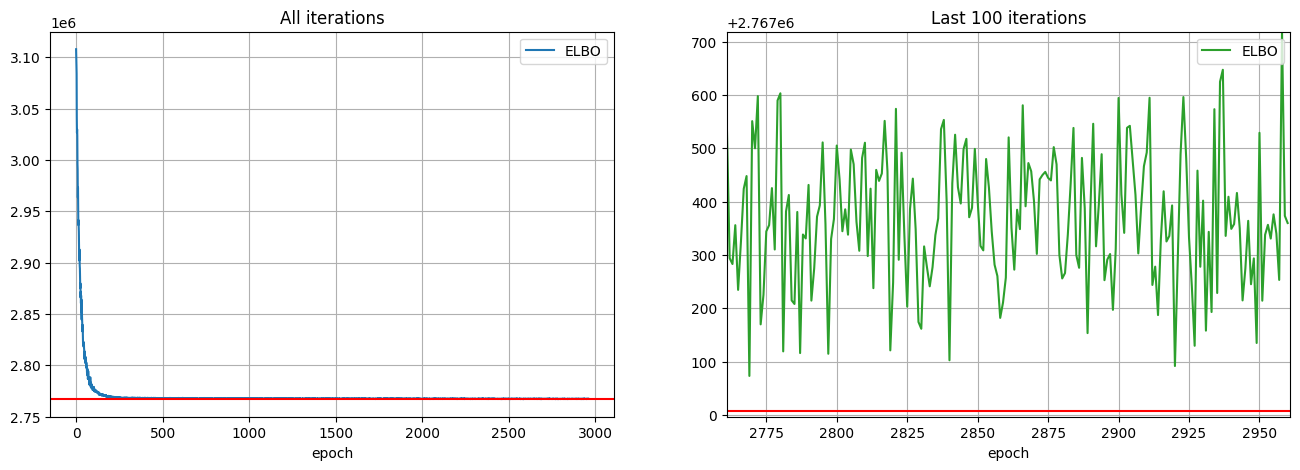

In [21]:
num_steps = 3000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

In [22]:
# Put estimations in new objects
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

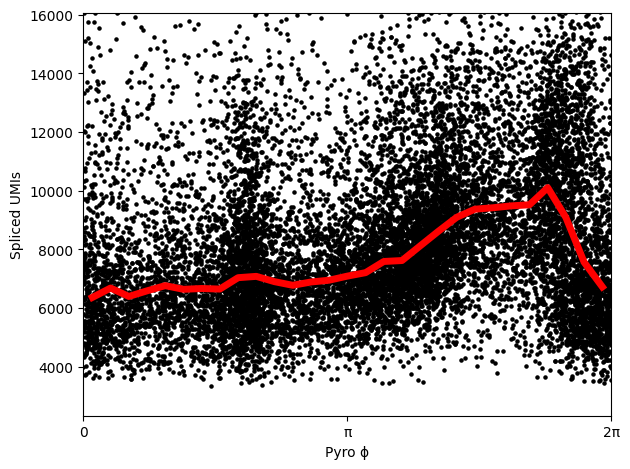

In [23]:
nbins=30
means_x = []
means_y = []

for lo, up in zip(np.linspace(0, 2*np.pi, nbins)[:-1], np.linspace(0, 2*np.pi, nbins)[1:]):
    means_x.append(np.mean([lo,up]))
    subset = np.where((phase_pyro.phis.numpy()>=lo) & (phase_pyro.phis.numpy()<up))
    means_y.append(np.median(np.array(data_to_fit.obs.n_scounts)[subset]))

plt.scatter(phase_pyro.phis.numpy(), data_to_fit.obs.n_scounts, s=5, c='black', rasterized=True) 
plt.plot(means_x, means_y, color='red', linewidth=5)
plt.ylim(min(data_to_fit.obs.n_scounts)-1000, np.percentile(data_to_fit.obs.n_scounts, 98)+1000)
plt.xlabel("Pyro ϕ")
plt.ylabel("Spliced UMIs")
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])

plt.tight_layout()
plt.show()

In [24]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze().mean(0).numpy()
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze().mean(0).numpy()

## Estimate the predicted unspliced-spliced shifts
## We want to remove genes with a predicted negative shirt 
## and/or a low cross correlation between the unspliced and spliced counts

In [25]:
ζ = phase_fit.posterior["ζ"].mean(0).squeeze().numpy()
phis = phase_fit.phase_pyro.phis

import statsmodels.api as sm
Ng = data_to_fit.n_vars
nu = np.zeros((Ng, 3))

Sraw = data_to_fit.layers["spliced"].toarray()
Uraw = data_to_fit.layers["unspliced"].toarray()
for g in range(Ng):
    y_col = Sraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nu[g, :] = model.params

nuU = np.zeros((Ng, 3))
for g in range(Ng):
    y_col = Uraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nuU[g, :] = model.params

ElogS = (ζ @ nu.T)
ElogU = (ζ @ nuU.T)

import pycircstat
shift_pred = pycircstat.cdiff(phis[np.argmax(ElogS, axis=0)], phis[np.argmax(ElogU, axis=0)])

In [26]:
corrs = []
for i in range(0, ElogS.shape[1]):
    corrs.append(np.corrcoef(ElogS[:, i], ElogU[:, i])[0, 1])
corrs = np.array(corrs)

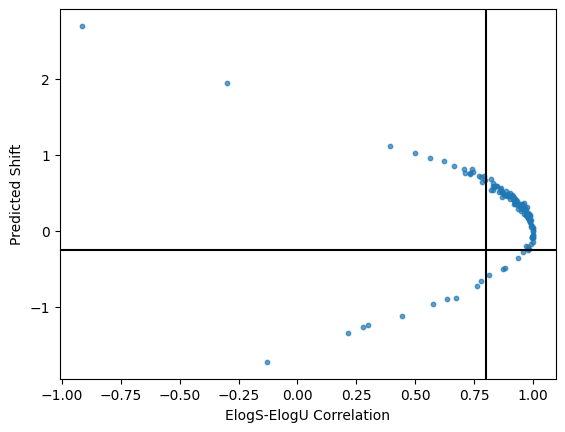

In [27]:
plt.scatter(corrs, shift_pred, s=10, alpha=0.7)
plt.xlabel("ElogS-ElogU Correlation")
plt.ylabel("Predicted Shift")
plt.axvline(0.8, c='black')
plt.axhline(-0.25, c='black')
plt.show()

In [28]:
keep_bool = (corrs>=0.8) & (shift_pred>=-0.25)

In [29]:
# Remove the small number of genes without good cross-correlation and repeat manifold-learning

In [30]:
cycle_pyro_filt = cycle.Cycle.from_array(means_array=cycle_pyro.means_tensor[:, keep_bool],
                       stds_array=cycle_pyro.stds_tensor[:, keep_bool], 
                       gene_names=cycle_pyro.means.columns[keep_bool])

In [31]:
sum(keep_bool) # number of genes kept

103

In [32]:
data = anndata.concat(full_adatas, label="batch", join ="outer")

In [33]:
data.var.index = np.array([i.upper() for i in data.var.index])

In [34]:
# Create design matrix for dataset with a single batch
batch_design_matrix = preprocessing.make_design_matrix(data, ids="batch")

In [35]:
# Rough approximation of the cell cycle phase using traditional approaches 
sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [36]:
# Perform some very basic gene filtering
data = data[:, data.layers["unspliced"].toarray().mean(0) > 0.1].copy()
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.1].copy()
data

AnnData object with n_obs × n_vars = 14259 × 4862
    obs: 'batch', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [37]:
# Create size normalized data for the phase estimate prior
preprocessing.normalize_total(data)

## Re-initialize cycle and phase objects with priors

In [38]:
full_keep_genes = np.array(cycle_pyro_filt.genes)
len(full_keep_genes)

103

In [39]:
n_harm = 1
cycle_prior = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=n_harm)

In [40]:
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [41]:
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

if(n_harm==2): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0, 0*nu0, 0*nu0))
if(n_harm==1): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
if(n_harm==0): S_frac_means=nu0[None, :]
cycle_prior.set_means(S_frac_means)

nu0std = np.std(np.log(S+1), axis=0)/2
if(n_harm==2): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std, 0.2*nu0std, 0.2*nu0std))
if(n_harm==1): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
if(n_harm==0): S_frac_stds=nu0[None, :]
cycle_prior.set_stds(S_frac_stds)

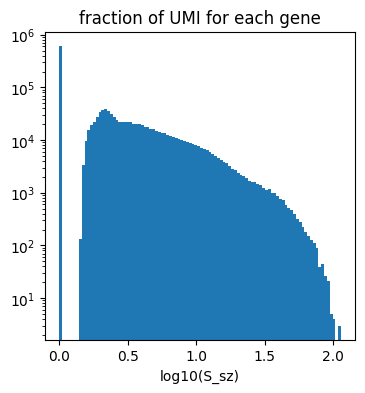

In [42]:
OFFSET=1
fig, ax = plt.subplots(1,1, figsize = (4,4))
ax.set_title('fraction of UMI for each gene')
ax.hist(np.log10(data_to_fit.layers['S_sz'].flatten()+OFFSET), bins = 100)
ax.set_yscale("log")
ax.set_xlabel("log10(S_sz)")
plt.show()

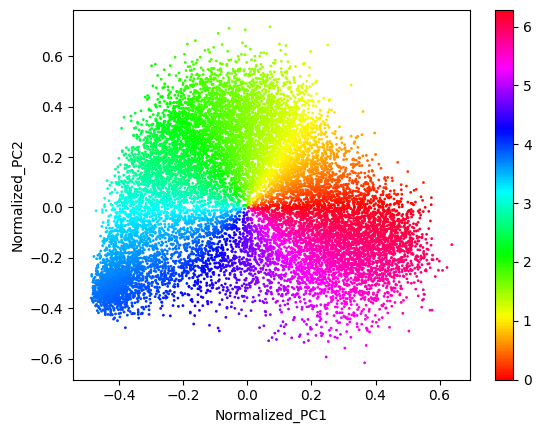

In [43]:
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, genes_to_use=utils.get_cycling_gene_set(size="Small", species="Human"), layer='S_sz', 
                                                   concentration=5.0, plot=True, small_count=OFFSET)

In [44]:
preprocessing.invert_direction(cycle_prior, phase_prior)

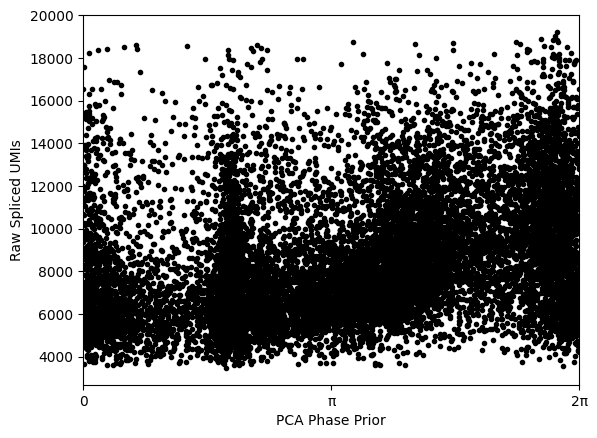

In [45]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

## Run the manifold-learning module on cross-correlating genes

In [46]:
pyro.clear_param_store()

In [47]:
μΔν = torch.zeros((batch_design_matrix.shape[1], S.shape[1], 1))
σΔν = torch.ones((batch_design_matrix.shape[1], S.shape[1], 1))
σΔν[0, :, :] = 0.001
σΔν[1, :, :] = 0.1

condition_on_dict = {}

In [48]:
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, 
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix.float(),
                                          normalize=False, 
                                          behavior="intersection", 
                                          noisemodel="NegativeBinomial", 
                                          gene_selection_model="all",
                                          n_harmonics=n_harm, 
                                          device = device,
                                          condition_on=condition_on_dict)

In [49]:
phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar, 
                                                condition_on=condition_on_dict,
                                                early_exit=False, num_samples=500, n_per_bin=50)

In [50]:
phase_fit.check_model()

 Trace Shapes:                                  
  Param Sites:                                  
 Sample Sites:                                  
    cells dist               |                  
         value         14259 |                  
    genes dist               |                  
         value           103 |                  
  batches dist               |                  
         value             2 |                  
        ν dist     103     1 |     3            
         value     103     1 |     3            
       Δν dist   2 103     1 |                  
         value   2 103     1 |                  
      ϕxy dist         14259 |     2            
         value         14259 |     2            
        ϕ dist               | 14259            
         value               | 14259            
        ζ dist               | 14259 3          
         value               | 14259 3          
    ElogS dist               |     1 1 103 14259
         value      

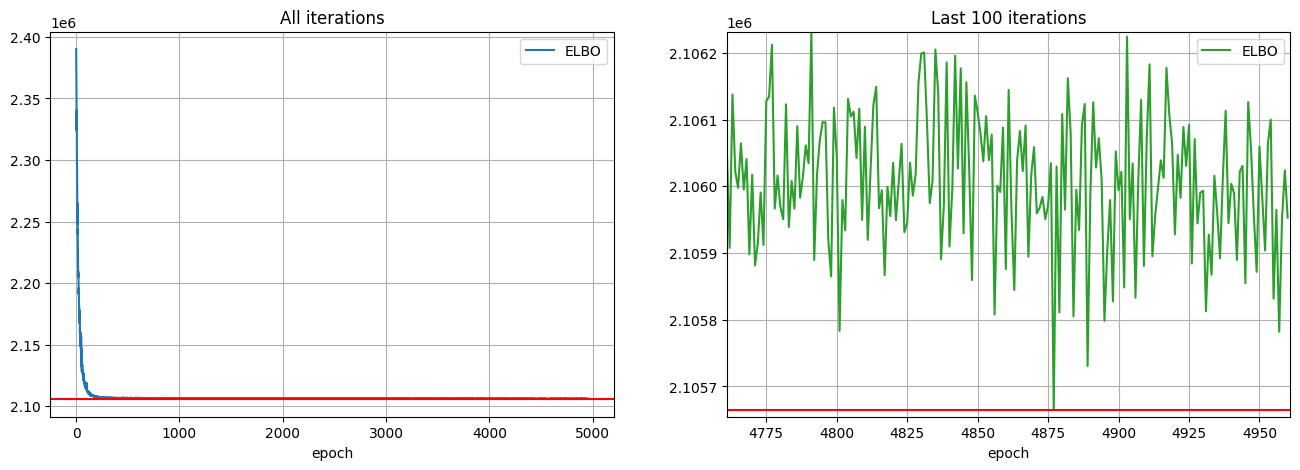

In [51]:
num_steps = 5000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

In [52]:
# Put estimations in new objects
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

In [53]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze().numpy()
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze().numpy()

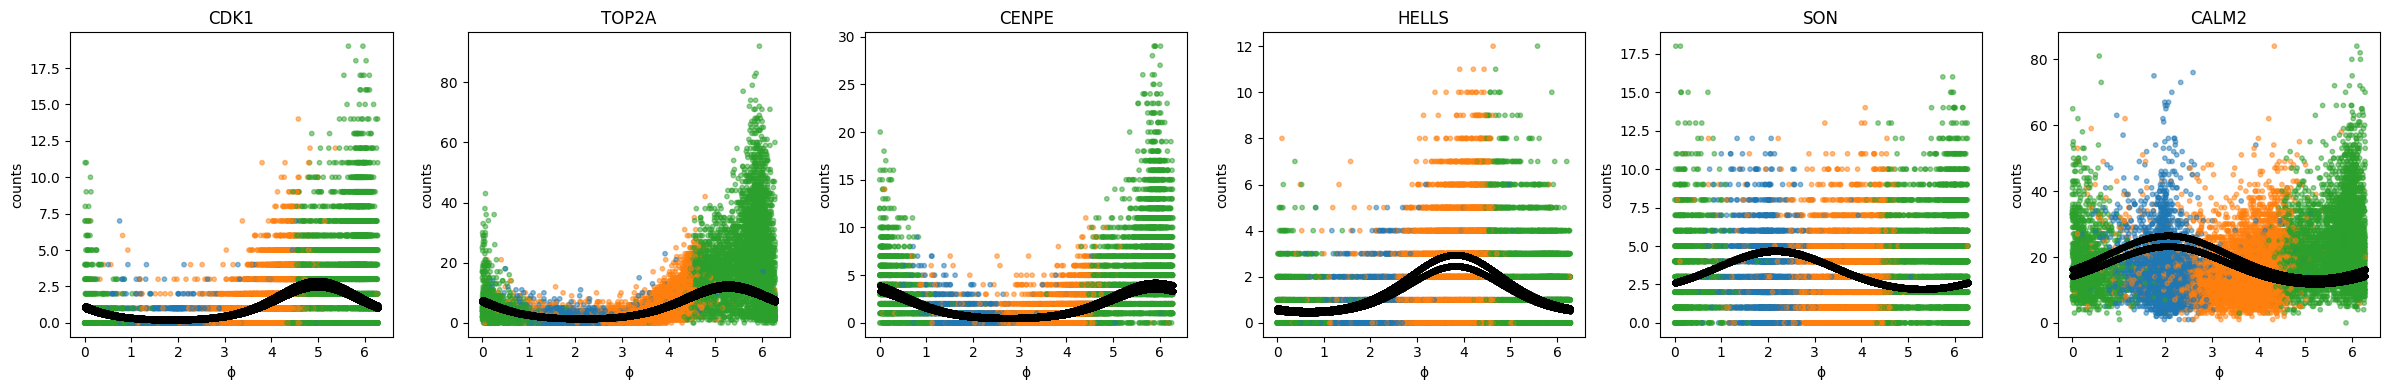

In [54]:
name2color = {'Non-cycling':"tab:brown", 'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_list = ["CDK1", "TOP2A", "CENPE", "HELLS", "SON", "CALM2"]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(phase_pyro.phis, 
                metapar.S[np.where(gene_names==g)[0][0], :].squeeze().cpu().numpy(), 
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["phase"]])
    plt.scatter(phase_pyro.phis, 
                np.exp(fit_ElogS2[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("counts")
    ix+=1
plt.tight_layout()
plt.show()

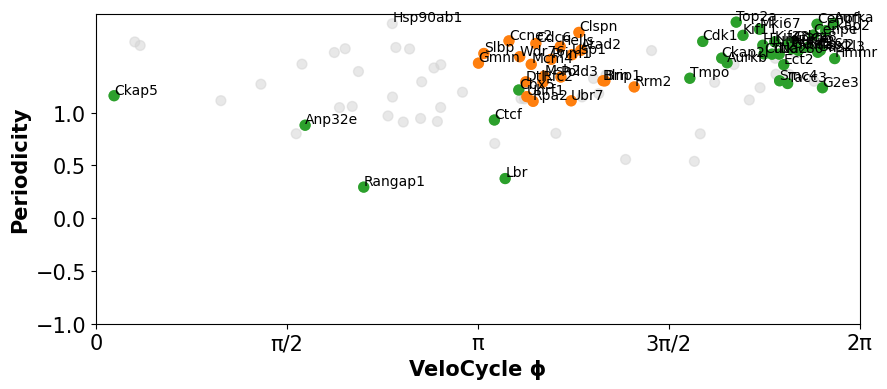

In [55]:
keep_genes = [a.upper() for a in cycle_prior.means.columns]

gene_names = np.array(keep_genes)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.transforms as mtransforms
from cmcrameri import cm
import seaborn as sns

keep_genes = [a.upper() for a in cycle_prior.means.columns]
gene_names = np.array(keep_genes)
S_genes_human = list(utils.S_genes_human)
G2M_genes_human = list(utils.G2M_genes_human)
phases_list = [S_genes_human, G2M_genes_human, [i.upper() for i in gene_names if i.upper() not in S_genes_human+G2M_genes_human]]

g = []
gradient = []
for i in range(len(phases_list)):
    for j in range(len(phases_list[i])):
        g.append(phases_list[i][j])
        gradient.append(i)

color_gradient_map = pd.DataFrame({'Gene': g,  'Color': gradient}).set_index('Gene').to_dict()['Color']
colored_gradient = pd.Series(gene_names).map(color_gradient_map)

xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle) % (2*np.pi)

N=50
width = (2*np.pi) / N

fig = plt.figure(figsize = (9, 4))
ax = fig.add_subplot()#projection='polar')

# First: only plot dots with a color assignment
angle_subset = angle[~np.isnan(colored_gradient.values)]
r_subset = r[~np.isnan(colored_gradient.values)]
color_subset = colored_gradient.values[~np.isnan(colored_gradient.values)]

# Remove genes with very low expression
angle_subset = angle_subset[r_subset>=-12]
color_subset = color_subset[r_subset>=-12]
gene_names_subset = gene_names[r_subset>=-12]
r_subset = r_subset[r_subset>=-12]

# Take a subset of most highly expressing genes to print the names 
angle_subset_best = angle_subset[r_subset>np.percentile(r_subset, 98)]
color_subset_best = color_subset[r_subset>=np.percentile(r_subset, 98)]
gene_names_subset_best = gene_names_subset[r_subset>=np.percentile(r_subset, 98)]
r_subset_best = r_subset[r_subset>=np.percentile(r_subset, 98)]

# Plot all genes in phases list
num2color = {0:"tab:orange", 1:"tab:green", 2:"lightgrey", 3:"tab:blue"}
ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=0.5)

# Select and plot on top the genes marking S and G2M traditionally
angle_subset = angle_subset[color_subset!=2]
r_subset = r_subset[color_subset!=2]
gene_names_subset = gene_names_subset[color_subset!=2]
color_subset = color_subset[color_subset!=2]

ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=1)

# Annotate genes
for (i, txt), c in zip(enumerate(gene_names), colored_gradient.values):
    if not np.isnan(c) and c!=2: # Genes from S and G2M lists
        ix = np.where(np.array(gene_names)==txt)[0][0]
        ax.annotate(txt[0].upper()+txt[1:].lower(), (angle[ix], r[ix]+0.02))
    elif txt in gene_names_subset_best: # Other genes with high overall expression
        ix = np.where(np.array(gene_names)==txt)[0][0]
        ax.annotate(txt[0].upper()+txt[1:].lower(), (angle[ix], r[ix]+0.02))

plt.xlabel("VeloCycle ϕ", size=15, fontweight='bold')
plt.ylabel("Periodicity", size=15, fontweight='bold')
plt.xlim(0, 2*np.pi)
plt.ylim(-1, )
plt.yticks([-1, -0.5, 0, 0.5, 1], size=15)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"], size=15)
plt.tight_layout()

In [56]:
ζ = phase_fit.posterior["ζ"].mean(0).squeeze().numpy()
phis = phase_fit.phase_pyro.phis

import statsmodels.api as sm
Ng = data_to_fit.n_vars
nu = np.zeros((Ng, 3))

Sraw = data_to_fit.layers["spliced"].toarray()
Uraw = data_to_fit.layers["unspliced"].toarray()
for g in range(Ng):
    y_col = Sraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nu[g, :] = model.params

nuU = np.zeros((Ng, 3))
for g in range(Ng):
    y_col = Uraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nuU[g, :] = model.params

ElogS = (ζ @ nu.T)
ElogU = (ζ @ nuU.T)

import pycircstat
shift_pred = pycircstat.cdiff(phis[np.argmax(ElogS, axis=0)], phis[np.argmax(ElogU, axis=0)])

corrs = []
for i in range(0, ElogS.shape[1]):
    corrs.append(np.corrcoef(ElogS[:, i], ElogU[:, i])[0, 1])
corrs = np.array(corrs)

In [57]:
xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

phis_df = pd.DataFrame([angle, r])
phis_df.columns = data_to_fit.var.index

phase_data_frame = pd.concat([phase_fit.cycle_pyro.means, phase_fit.cycle_pyro.stds, phis_df]).T
phase_data_frame.columns = ["nu0 mean", "nu1sin mean", "nu1cos mean",
                            "nu0 std", "nu1sin std", "nu1cos std", "peak_phase", "amplitude"]
phase_data_frame["is_seurat_marker"] = [True if i in list(utils.S_genes_human)+list(utils.G2M_genes_human) else False for i in phase_data_frame.index]
phase_data_frame.head()

phis_df = pd.DataFrame(phase_fit.phase_pyro.phis.numpy())
phis_df.index = data_to_fit.obs.index
phis_df.columns = ["cell_cycle_phi"]
phase_data_frame_cells = data_to_fit.obs.merge(phis_df, left_index=True, right_index=True)
phase_data_frame["shift_pred"] = shift_pred
phase_data_frame["ElogS_ElogU_correlation"] = corrs

In [58]:
# Store output to compare later against those obtained with the unspliced
angle_subsetS = copy.deepcopy(angle_subset)
r_subsetS = copy.deepcopy(r_subset)
angleS = copy.deepcopy(angle)
rS = copy.deepcopy(r)

# Fit the unspliced in the same manner as the spliced

# This will let us compare the unspliced-spliced delay with both obtained from the model directly

In [59]:
n_harm = 1
cycle_priorU = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=n_harm)

In [60]:
dataU = data.copy()
dataU.layers["spliced"] = dataU.layers["unspliced"]
dataU.X = dataU.layers["unspliced"]

In [61]:
cycle_priorU, data_to_fitU = preprocessing.filter_shared_genes(cycle_priorU, dataU, filter_type="intersection")

In [62]:
S = data_to_fitU.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

if(n_harm==2): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0, 0*nu0, 0*nu0))
if(n_harm==1): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
if(n_harm==0): S_frac_means=nu0[None, :]
cycle_priorU.set_means(S_frac_means)

nu0std = np.std(np.log(S+1), axis=0)/2
if(n_harm==2): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std, 0.2*nu0std, 0.2*nu0std))
if(n_harm==1): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
if(n_harm==0): S_frac_stds=nu0[None, :]
cycle_priorU.set_stds(S_frac_stds)

In [63]:
phase_priorU = phase_pyro

In [64]:
pyro.clear_param_store()

In [65]:
μΔν = torch.zeros((batch_design_matrix.shape[1], S.shape[1], 1))
σΔν = torch.ones((batch_design_matrix.shape[1], S.shape[1], 1))
σΔν[0, :, :] = 0.001
σΔν[1, :, :] = 0.1

condition_on_dictU = {"ϕxy":phase_priorU.phi_xy_tensor.T.to(device)}

In [66]:
metaparU = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fitU, 
                                          cycle_obj=cycle_priorU, 
                                          phase_obj=phase_priorU, 
                                          design_mtx=batch_design_matrix.float(),
                                          normalize=False, 
                                          behavior="intersection", 
                                          noisemodel="NegativeBinomial", 
                                          gene_selection_model="all",
                                          n_harmonics=n_harm, 
                                          device = device,
                                          condition_on=condition_on_dict)

In [67]:
phase_fitU = phase_inference_model.PhaseFitModel(metaparams=metaparU, 
                                                condition_on=condition_on_dictU,
                                                early_exit=False, num_samples=500, n_per_bin=50)

In [68]:
phase_fitU.check_model()

 Trace Shapes:                                  
  Param Sites:                                  
 Sample Sites:                                  
    cells dist               |                  
         value         14259 |                  
    genes dist               |                  
         value           103 |                  
  batches dist               |                  
         value             2 |                  
        ν dist     103     1 |     3            
         value     103     1 |     3            
       Δν dist   2 103     1 |                  
         value   2 103     1 |                  
      ϕxy dist         14259 |     2            
         value         14259 |     2            
        ϕ dist               | 14259            
         value               | 14259            
        ζ dist               | 14259 3          
         value               | 14259 3          
    ElogS dist               |     1 1 103 14259
         value      

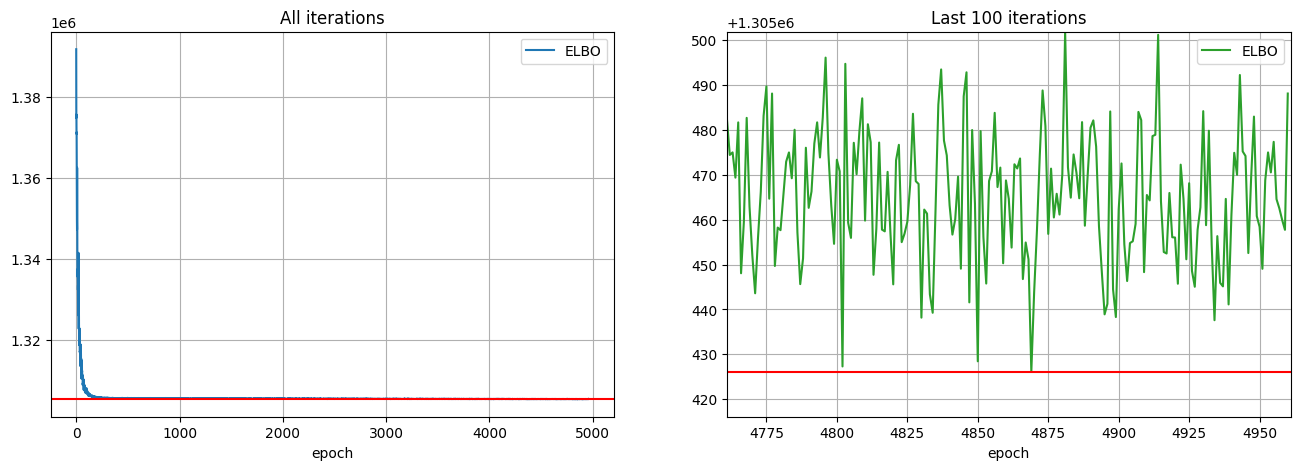

In [69]:
num_steps = 5000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fitU.fit(optimizer=adam, num_steps=num_steps)

In [70]:
# Put estimations in new objects
cycle_pyroU = phase_fitU.cycle_pyro
phase_pyroU = phase_fitU.phase_pyro

fit_ElogU = phase_fitU.posterior["ElogS"].squeeze().numpy()
fit_ElogU2 = phase_fitU.posterior["ElogS2"].squeeze().numpy()

In [71]:
np.alltrue((phase_pyroU.phis == phase_pyro.phis).numpy())

True

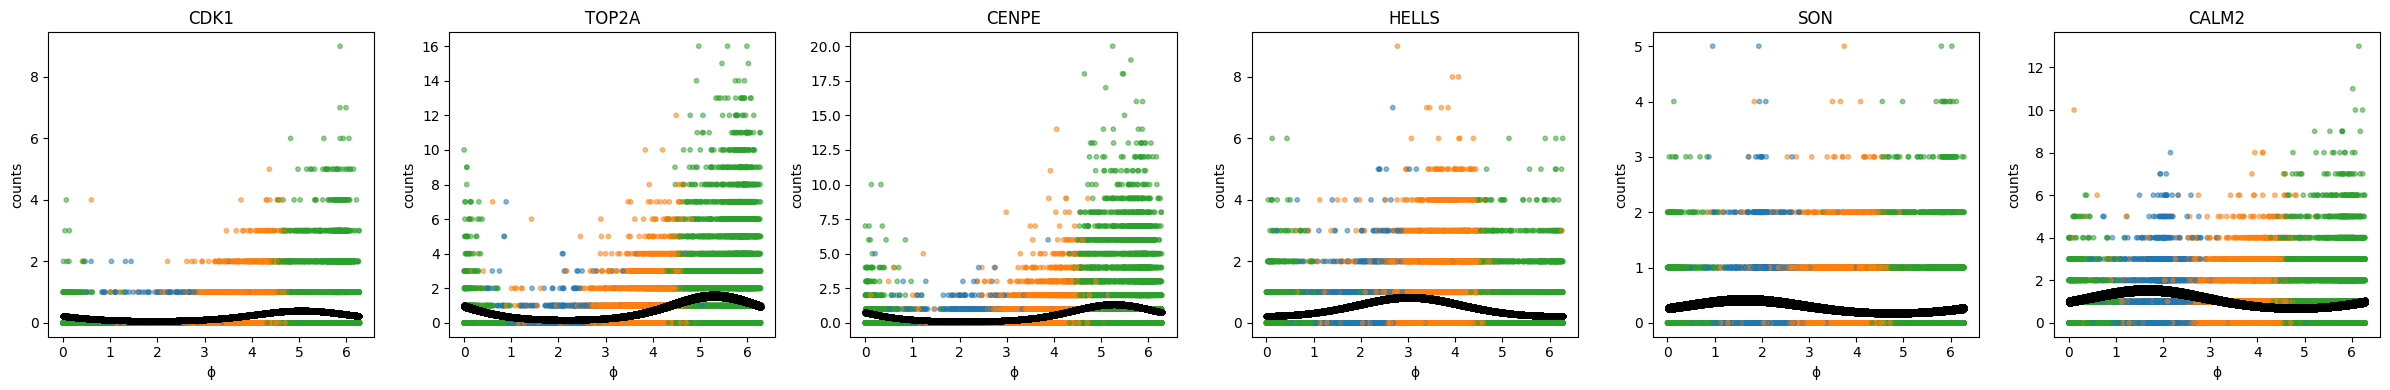

In [72]:
name2color = {'Non-cycling':"tab:brown", 'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_names = np.array(data_to_fitU.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(phase_pyroU.phis, 
                metaparU.S[np.where(gene_names==g)[0][0], :].squeeze().cpu().numpy(), 
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fitU.obs["phase"]])
    plt.scatter(phase_pyroU.phis, 
                np.exp(fit_ElogU2[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("counts")
    ix+=1
plt.tight_layout()
plt.show()

In [73]:
angle_subsetU = copy.deepcopy(angle_subset)
r_subsetU = copy.deepcopy(r_subset)
angleU = copy.deepcopy(angle)
rU = copy.deepcopy(r)

# Make plots to directly compare the spliced/unspliced nu harmonics obtained jointly on the two replicates

In [74]:
gene_names = np.array([i for i in range(metapar.Ng)])

phis = phase_pyro.phis.numpy()
shifts = []
for g in gene_names:
    i = g
    Upeak = phis[np.where(fit_ElogU2[i, :] == max(fit_ElogU2[i, :]))[0][0]]
    Speak = phis[np.where(fit_ElogS2[i, :] == max(fit_ElogS2[i, :]))[0][0]]
    shift = pycircstat.cdiff(Speak, Upeak)
    #shift = (shift+(np.pi*2)) % (np.pi*2)
    shifts.append(shift)
shifts = np.array(shifts)
np.mean(shifts)

0.43362394894157696

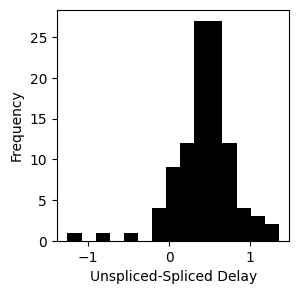

In [75]:
plt.figure(None, (3,3))
plt.hist(shifts, bins=15, color='black')
plt.xlabel("Unspliced-Spliced Delay")
plt.ylabel("Frequency")
plt.show()

In [76]:
# Compute shifts for each replicate individually

In [77]:
gene_names = np.array([i for i in range(metapar.Ng)])

shifts_rep1 = []
keep_bool = np.array(data_to_fit.obs["batch"]=="RPE_37C_ctrl_Rep1")
phis = phase_pyro.phis.numpy()[keep_bool]
for g in gene_names:
    i = g
    Upeak = phis[np.where(fit_ElogU2[i, keep_bool] == max(fit_ElogU2[i, keep_bool]))[0][0]]
    Speak = phis[np.where(fit_ElogS2[i, keep_bool] == max(fit_ElogS2[i, keep_bool]))[0][0]]
    shift = pycircstat.cdiff(Speak, Upeak)
    shifts_rep1.append(shift)
shifts_rep1 = np.array(shifts_rep1)
np.mean(shifts_rep1)

0.4336131414042389

In [78]:
gene_names = np.array([i for i in range(metapar.Ng)])

shifts_rep2 = []
keep_bool = np.array(data_to_fit.obs["batch"]=="RPE_37C_ctrl_Rep2")
phis = phase_pyro.phis.numpy()[keep_bool]
for g in gene_names:
    i = g
    Upeak = phis[np.where(fit_ElogU2[i, keep_bool] == max(fit_ElogU2[i, keep_bool]))[0][0]]
    Speak = phis[np.where(fit_ElogS2[i, keep_bool] == max(fit_ElogS2[i, keep_bool]))[0][0]]
    shift = pycircstat.cdiff(Speak, Upeak)
    shifts_rep2.append(shift)
shifts_rep2 = np.array(shifts_rep2)
np.mean(shifts_rep2)

0.43363570964688136

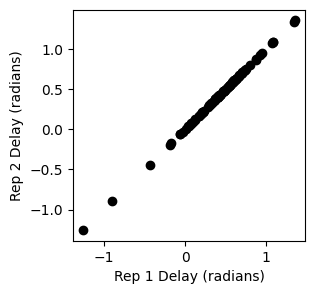

In [79]:
plt.figure(None, (3,3))
plt.scatter(shifts_rep1, shifts_rep2, color='black')
plt.xlabel("Rep 1 Delay (radians)")
plt.ylabel("Rep 2 Delay (radians)")
plt.show()

In [80]:
np.corrcoef(shifts_rep1, shifts_rep2)

array([[1.        , 0.99998424],
       [0.99998424, 1.        ]])

In [81]:
# Median of tan
m = np.array([list(a) for a in zip(shifts_rep1, shifts_rep2)])
half_life = 1
(2*np.pi*half_life)/(np.median(np.tan(m), axis =0)*np.log(2))

array([17.52301317, 17.76018109])

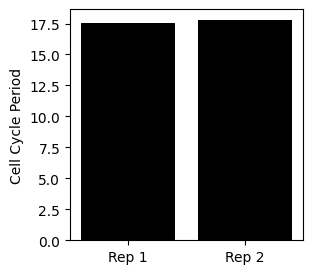

In [82]:
plt.figure(None, (3,3))
plt.bar([0, 1], (2*np.pi*half_life)/(np.median(np.tan(m), axis =0)*np.log(2)), color='black')
plt.xticks([0,1], ["Rep 1", "Rep 2"])
plt.ylabel("Cell Cycle Period")
plt.show()

In [83]:
# Load genes from CycleBase3.0
gene_list = pd.read_csv('human_periodic.tsv', sep='\t')
gene_symbol = pd.read_csv('gene_symbol.csv')
gene_list = gene_list.merge(gene_symbol, left_on = 'gene', right_on = 'Identifier')
columns_keep = ['gene', 'rank_x', 'peaktime', 'periodicity_pvalue' ,'Type',  'Primary name','Peaktime','Phenotypes']
gene_list = gene_list[columns_keep]

gene_list.head()

gene_list['Peaktime_phase'] = gene_list.peaktime*2*np.pi/100
colormap = dict({'G1': 1, 'G1/S': 2, 'S': 3, 'G2': 4, 'G2/M': 5, 'M':6})
phase_map = gene_symbol[['Primary name', 'Peaktime']].set_index('Primary name').to_dict()['Peaktime']

In [84]:
result = pd.DataFrame([data_to_fit.var.index, rS, angleS]).T
result.columns = ["Gene", "amplitudes", "angles"]

In [85]:
result = result[result["Gene"].isin(gene_symbol["Primary name"])]

In [86]:
bin_edges = [0, np.pi/4,  np.pi/2, 3*np.pi/4,np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4, 2*np.pi]
result['group'] = pd.cut(result['angles'], bins=bin_edges)
result = result.sort_values('amplitudes')

In [87]:
gene_0 = result["Gene"]

In [88]:
gs = result.index
g_index = gs   

In [89]:
xs = np.array(phase_fit.cycle_pyro.means.loc["nu1_sin"])[g_index]
ys = np.array(phase_fit.cycle_pyro.means.loc["nu1_cos"])[g_index]

xs_U = np.array(phase_fitU.cycle_pyro.means.loc["nu1_sin"])[g_index]
ys_U = np.array(phase_fitU.cycle_pyro.means.loc["nu1_cos"])[g_index]

In [90]:
len(g_index)

66

In [91]:
cmap = 'gist_rainbow'

[6.168462, 0.07678382] [-0.90019655, -0.82934356]
[5.835596, 0.14997517] [-0.5079086, -0.8656148]
[6.1334896, 0.43260497] [-0.5532558, -0.7185067]
[5.9287786, 0.12420008] [-0.48945317, -0.42041343]


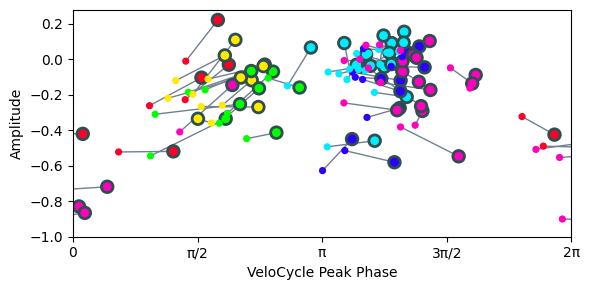

In [92]:
plt.figure(None, (6,3))

# Find the y-values for the linear interpolation between the two points
def interpolate_y(x, p1, p2):
    # Calculate the slope
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    # Calculate the y-intercept
    b = p1[1] - m * p1[0]
    # Return the y-value
    return m * x + b
    
rU = np.log10( np.sqrt(xs_U**2+ys_U**2) )
angleU = np.arctan2(xs_U, ys_U)
angleU = (angleU*-1) % (2*np.pi)

rS = np.log10( np.sqrt(xs**2+ys**2) )
angleS = np.arctan2(xs, ys)
angleS = (angleS*-1) % (2*np.pi)

bool = (rS>=-1) & (rU>=-1)
angleS = angleS[bool]
angleU = angleU[bool]
rS = rS[bool]
rU = rU[bool]
colors = gene_0[g_index].map(phase_map).map(colormap)#.fillna(1)
colors = colors[bool]

plt.scatter(angleS, rS,  c=colors, s = 70, cmap =  cmap, edgecolor = 'darkslategrey', linewidth=2, rasterized=True)
plt.scatter(angleU, rU, c=colors, s = 70, cmap = cmap, marker = '.', rasterized=True)

for i in range(len(rS)):
    x = [angleU[i], angleS[i]]
    y = [rU[i], rS[i]]

    if (x[0] - x[1])>np.pi:
        print(x, y)
        # Separate the line into two segments: one from 6 to 2pi and the other from 0 to 1
        segment1_x = np.linspace(x[0], 2*np.pi, 100)
        segment2_x = np.linspace(0, x[1], 100)
        point1 = np.array([x[0], y[0]])
        point2 = np.array([x[1], y[1]])
        segment1_y = interpolate_y(segment1_x, point1, point2)
        segment2_y = interpolate_y(segment2_x, point1, point2)   
        plt.plot(segment1_x, segment1_y, c = 'slategrey', zorder = 0, linewidth = 1, linestyle = '-')
        plt.plot(segment2_x, segment2_y, c = 'slategrey', zorder = 0, linewidth = 1, linestyle = '-')
    else:
        plt.plot(x, y, c = 'slategrey', zorder = 0, linewidth = 1, linestyle = '-')

plt.xlim(0, 2*np.pi)
plt.ylim(-1, )
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.xlabel("VeloCycle Peak Phase")
plt.ylabel("Amplitude")
plt.tight_layout()

plt.show()

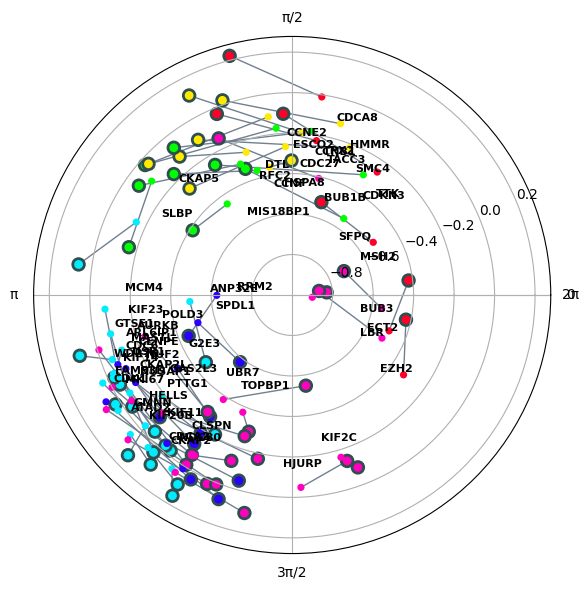

In [93]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='polar')

# Find the y-values for the linear interpolation between the two points
def interpolate_y(x, p1, p2):
    # Calculate the slope
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    # Calculate the y-intercept
    b = p1[1] - m * p1[0]
    # Return the y-value
    return m * x + b
    
rU = np.log10( np.sqrt(xs_U**2+ys_U**2) )
angleU = np.arctan2(xs_U, ys_U)
angleU = (angleU*-1) % (2*np.pi)

rS = np.log10( np.sqrt(xs**2+ys**2) )
angleS = np.arctan2(xs, ys)
angleS = (angleS*-1) % (2*np.pi)

bool = (rS>=-1) & (rU>=-1)
angleS = angleS[bool]
angleU = angleU[bool]
rS = rS[bool]
rU = rU[bool]
colors = gene_0[g_index].map(phase_map).map(colormap)#.fillna(1)
colors = colors[bool]

ax.scatter(angleS, rS,  c=colors, s = 70, cmap =  cmap, edgecolor = 'darkslategrey', linewidth=2, rasterized=True)
ax.scatter(angleU, rU, c=colors, s = 70, cmap = cmap, marker = '.', rasterized=True)

texts = gene_0[g_index]
for p, r, text in zip(angleU, rU, texts):
    ax.annotate(text, xy=(p -0.1, r-0.1), fontsize = 8, fontweight = 'bold')

for i in range(len(rS)):
    x = [angleU[i], angleS[i]]
    y = [rU[i], rS[i]]

    ax.plot(x, y, c = 'slategrey', zorder = 0, linewidth = 1, linestyle = '-')

plt.xlim(0, 2*np.pi)
plt.ylim(-1, )
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.tight_layout()
plt.show()

## Run the velocity-learning module

In [94]:
pyro.clear_param_store()

In [95]:
# One only condition, so the design matrix is the same as for batches
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [96]:
n_velo_harmonics = 0
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["RPE_37C_ctrl_Rep1", "RPE_37C_ctrl_Rep2"], harmonics=n_velo_harmonics, 
                                                means=0.0, stds=3.0)

In [97]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "Δν": torch.tensor(phase_fit.delta_nus).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [98]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix.float(), 
                                                             batch_design_matrix.float(), 
                                                             n_harmonics=n_harm,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=n_velo_harmonics, 
                                                             gene_selection_model="all",
                                                             normalize=False,
                                                             noisemodel="NegativeBinomial",
                                                             μγ=torch.tensor(0.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             σγ=torch.tensor(0.5).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             μβ=torch.tensor(2.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             σβ=torch.tensor(3.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             device=device, 
                                                             model_type="lrmn",
                                                             rho_mean=torch.tensor(4.0).to(device),
                                                             rho_rank=torch.tensor(5).to(device),
                                                             condition_on=condition_on_dict)

In [99]:
velocity_fit = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict, early_exit=False)

In [100]:
velocity_fit.check_model()

  Trace Shapes:                                        
   Param Sites:                                        
  Sample Sites:                                        
     cells dist                 |                      
          value           14259 |                      
     genes dist                 |                      
          value             103 |                      
 harmonics dist                 |                      
          value               1 |                      
conditions dist                 |                      
          value               2 |                      
   batches dist                 |                      
          value               2 |                      
     logγg dist       103     1 |                      
          value       103     1 |                      
     logβg dist       103     1 |                      
          value       103     1 |                      
  rho_real dist       103     1 |               

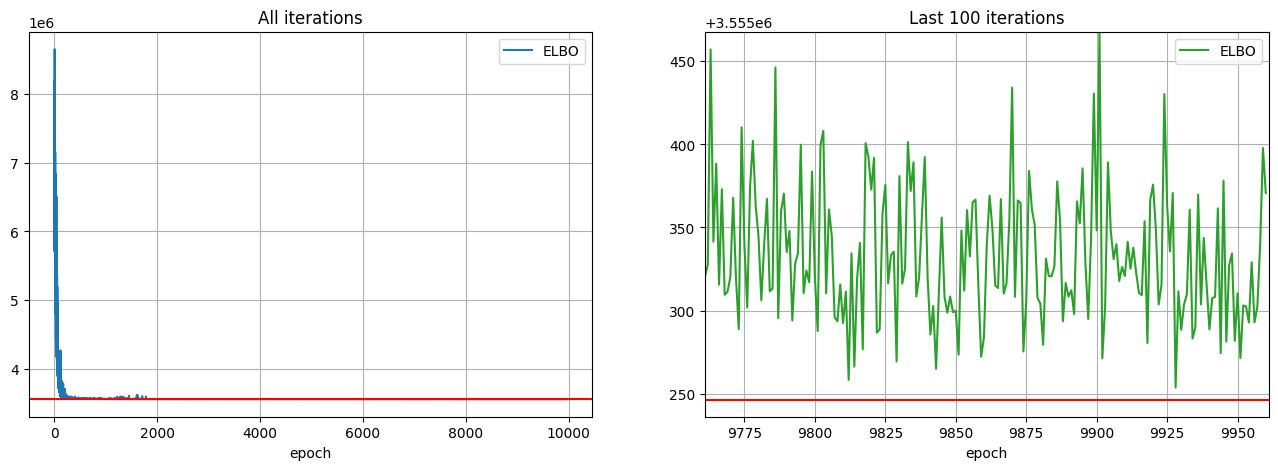

In [101]:
num_steps = 10000
initial_lr = 0.02
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit.fit(optimizer=adam, num_steps=num_steps)

In [102]:
# Put estimations in new objects
cycle_pyro = velocity_fit.cycle_pyro
phase_pyro = velocity_fit.phase_pyro
speed_pyro = velocity_fit.speed_pyro

fit_ElogS = velocity_fit.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit.posterior["ElogU2"].squeeze()

In [103]:
log_gammas = velocity_fit.log_gammas
log_betas = velocity_fit.log_betas

In [104]:
np.exp(np.mean(log_gammas))

1.1244813

In [105]:
gene_names = np.array([i for i in range(metaparameters_velocity.Ng)])

phis = phase_pyro.phis.numpy()
shifts = []
for g in gene_names:
    i = g
    Upeak = phis[np.where(fit_ElogU[i, :] == max(fit_ElogU[i, :]))[0][0]]
    Speak = phis[np.where(fit_ElogS[i, :] == max(fit_ElogS[i, :]))[0][0]]
    shift = round(Speak-Upeak, 2)
    shift = (shift+(np.pi*2)) % (np.pi*2)
    shifts.append(shift)
shifts = np.array(shifts)
np.mean(shifts)

0.1729126219610566

In [106]:
full_pps_velo = velocity_fit.posterior

20.238363 0.22810763
20.18423 0.21395321


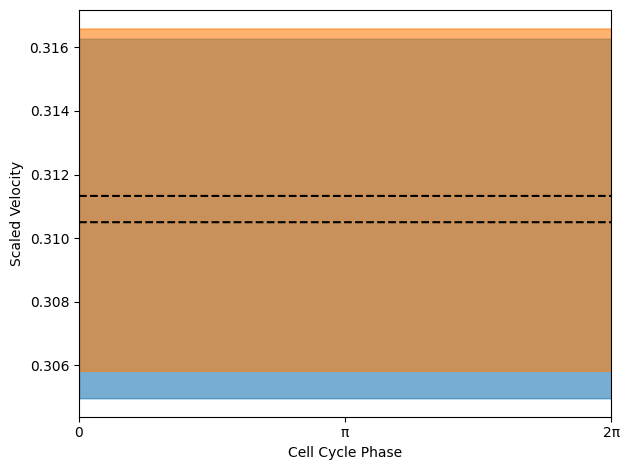

In [107]:
omega = full_pps_velo["ω"].squeeze().numpy() / np.exp(np.mean(log_gammas))
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"RPE_37C_ctrl_Rep1":0, "RPE_37C_ctrl_Rep2":1}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique()) #list(adatas.keys())

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    print(((2*np.pi)/omega[:, ids==i]).mean(), ((2*np.pi)/omega[:, ids==i]).std())
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])

plt.xlabel("Cell Cycle Phase")
plt.ylabel("Scaled Velocity")

plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.tight_layout()
plt.show()

In [108]:
from scipy.integrate import trapz
period = []

mean_gamma  = np.exp(np.mean(velocity_fit.log_gammas))
full_pps_velo = velocity_fit.posterior
nu_omega = full_pps_velo["νω"].squeeze()/mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega[:, 0].unsqueeze(-1) @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=0).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 95)-np.percentile(period, 5)), np.mean(period)

(0.3687115669250485, 20.238375)

In [109]:
from scipy.integrate import trapz
period = []

mean_gamma  = np.exp(np.mean(velocity_fit.log_gammas))
full_pps_velo = velocity_fit.posterior
nu_omega = full_pps_velo["νω"].squeeze()/mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega[:, 1].unsqueeze(-1) @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=0).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 95)-np.percentile(period, 5)), np.mean(period)

(0.3496734619140618, 20.184275)